# CNN Cancer Detection Project

In this project we will perform binary image classification using a dataset of images to identify metastatic cancer from larger digital pathology scans. This study is incredibly important in accurately and quickly identifying cancer. To identify cancer via these photos and expert must spend a significant amount of time on an extremely tedious process. By creating a neural network model to identify if cancer is present, we can significantly reduce the time spent by experts freeing up more of their time and effective reducing cost. 

As we proceed into this project we will perform a few stages to achieve our goal of identifying metstatic cancer:
1. Loading Data
2. Exploratory Data Analysis
3. Neural Network Modeling
4. Conclusion

## Modules

To start off we will load are modules. For this project we will be using tenserflow and its Keras backend for building and training the neural network. We will also use several basic data analysis models to aid us in loading data.

- glob - for loading files
- os - for parsing windows file strings
- cv2 - for loading images
- tqdm - for progess bars on loading image files
- matplotlib - graphing and visuals
- numpy and pandas - for math and data structures
module

In [3]:
from glob import glob 
import numpy as np
import pandas as pd
import os, cv2
import random

import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

import gc

#### This is a useful code for identifying if tensorflow has accurately found your GPU

In [4]:
### make sure tensorflow is using GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available: ' , len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Loading Data

To start off with we can load the data. We will start by noting where the train labels and create paths to all the files. This will make it easy in the future to switch to a different file location if it is necessary. We will also perform a quick check on the Label distribution in the train_labels file. We see that around 130,000 files are labeled as 0 with around 90,000 labeled as 1. When training the model it will likely be best to load a subset of the dataset to make sure 0 and 1 are equal. 

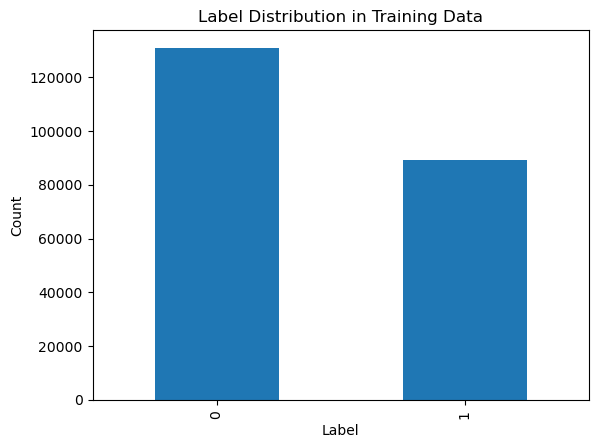

label
0    130907
1     89117
Name: count, dtype: int64


In [38]:
base_path = r'C:\Users\Ryan\Files\DTSA 5511'
train_labels = pd.read_csv(os.path.join(base_path, 'train_labels.csv'))
train_path = os.path.join(base_path, 'train/')
test_path = os.path.join(base_path, 'test/')
# quick look at the label stats
dist = train_labels['label'].value_counts()

dist.plot(kind='bar')
plt.title('Label Distribution in Training Data')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

print(dist)

In [4]:
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


#### Next we can load all the files and their paths using the glob function. 

In [39]:
train_image_paths = glob(os.path.join(train_path, '*.tif'))
test_image_paths = glob(os.path.join(test_path, '*.tif'))

print("train_image_size :", len(train_image_paths))
print("test_image_size :", len(test_image_paths))

train_image_size : 220025
test_image_size : 57458


In [6]:
train_image_paths[:6]

['C:\\Users\\Ryan\\Files\\DTSA 5511\\train\\00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif',
 'C:\\Users\\Ryan\\Files\\DTSA 5511\\train\\000020de2aa6193f4c160e398a8edea95b1da598.tif',
 'C:\\Users\\Ryan\\Files\\DTSA 5511\\train\\00004aab08381d25d315384d646f5ce413ea24b1.tif',
 'C:\\Users\\Ryan\\Files\\DTSA 5511\\train\\0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif',
 'C:\\Users\\Ryan\\Files\\DTSA 5511\\train\\0000da768d06b879e5754c43e2298ce48726f722.tif',
 'C:\\Users\\Ryan\\Files\\DTSA 5511\\train\\0000f8a4da4c286eee5cf1b0d2ab82f979989f7b.tif']

### Loading Images

Now we can finally load the images. We have 2 functions below.

- load_images will load the images obtained from the get_file path. This function utilizes cv2 to load the images and tqdm to provide a status bar to track how much progress is being made.
- get_file_paths_by_label will get the file_paths for the images so we can later invoke the load_images function. It allows us to adjust how many files we want to load.

In [7]:
def load_images(file_paths, image_size=(96, 96)):
    images = []
    for file in tqdm(file_paths, desc="Loading images"):
        img = cv2.imread(file)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
    return np.array(images)

# Function to get file paths
def get_file_paths_by_label(base_path, labels_df, label, n=5000):
    file_ids = labels_df[labels_df['label'] == label]['id'].sample(n=n).values
    file_paths = [os.path.join(base_path, f"{file_id}.tif") for file_id in file_ids]
    return file_paths

In [8]:
# Load a subset of train and test images
N = 5000
train_file_paths_0 = get_file_paths_by_label(train_path, train_labels, label=0, n=N)
train_file_paths_1 = get_file_paths_by_label(train_path, train_labels, label=1, n=N)

train_images_0 = load_images(train_file_paths_0)
train_images_1 = load_images(train_file_paths_1)

Loading images:   0%|          | 0/5000 [00:00<?, ?it/s]

Loading images:   0%|          | 0/5000 [00:00<?, ?it/s]

## Exploratory Data Analysis
Now that we have a function set to load the images, we can now proceed to perform a basic Exploratory Data Analysis to get some information about the pictures.

To start off, lets load 10 images to get an idea of what the images look like. We see that are data returned 5 with Label 1 and 5 with Label 0. Looking at these images, it shows how difficult a process it can be without really good knowledge. There isnt any easy way for a person without vast knowledge about cancer to identify which images have cancer cells and which do not. 

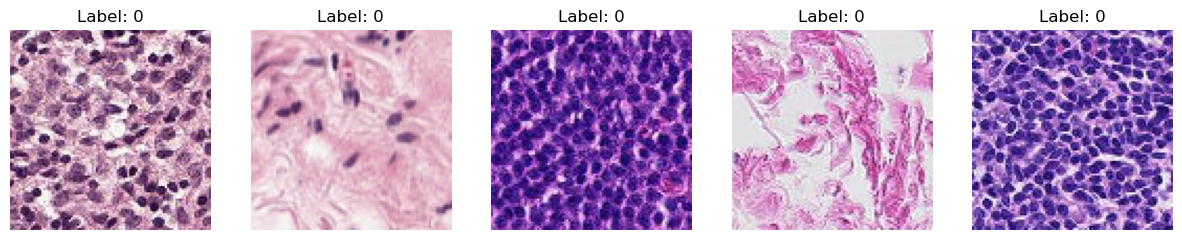

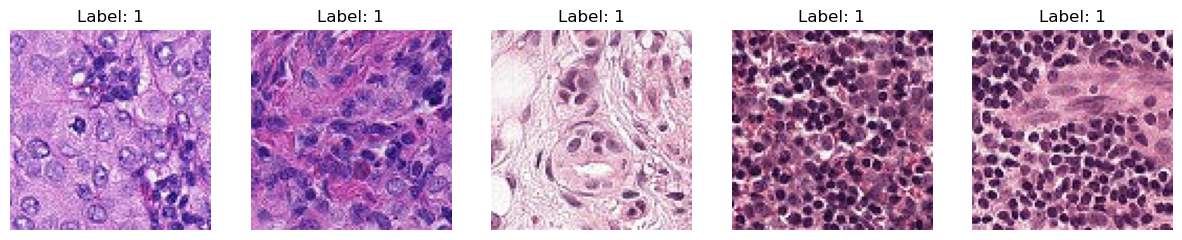

In [9]:
def plot_sample_images(images, labels, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    for i in range(n):
        axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Label: {labels[i]}")
        axes[i].axis('off')
    plt.show()

plot_sample_images(train_images_0[:5], [0]*5)
plot_sample_images(train_images_1[:5], [1]*5)

### RGB Analysis
With the previous understanding of this lets check the distribution of colors and brightness in the pictures. For the 10,000 samples we are looking at for this EDA we will check the RGB values and create Distribution charts for each of their colors and brightness.

#### Negative vs Positive

Interestingly, the distribution of colors for Positive and Negative cases appear quite different.

- Red color in Positive cancer cases have a far higher freqency at high levels of Red betwenn 150 and 200, but lower above 200.
- Green is far less present at high visibilty in positive cancer cases. It has a high frequency in 50-150 range.
- Blue also appears to have a higher frequency at high degrees of blue.
- Brightness also appear to be generally lower. The Negative cases has 2 main spikes with one of the spikes at high brightness levels, while positive cases tend to be focus more around the 150 mark.

In general it seems that images with less Red likely constituing red blood cells being healthy are more likely to have cancer. 

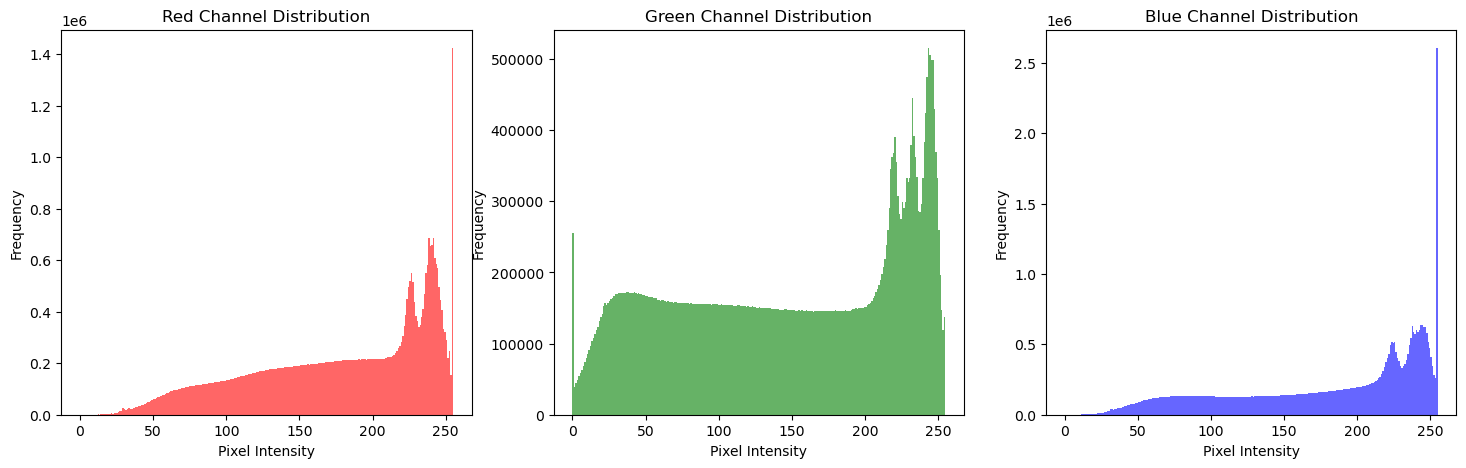

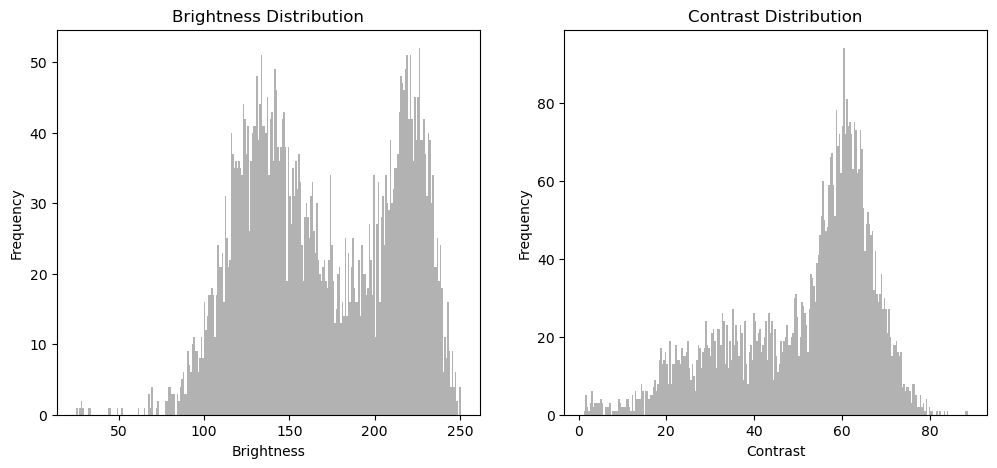

Label 0 - Mean: [179.33827485 147.03097496 181.50118878], Std: [59.64076436 76.94494559 64.89034885]
Label 0 - Average Brightness: 169.29014619502317, Average Contrast: 51.401394258955015


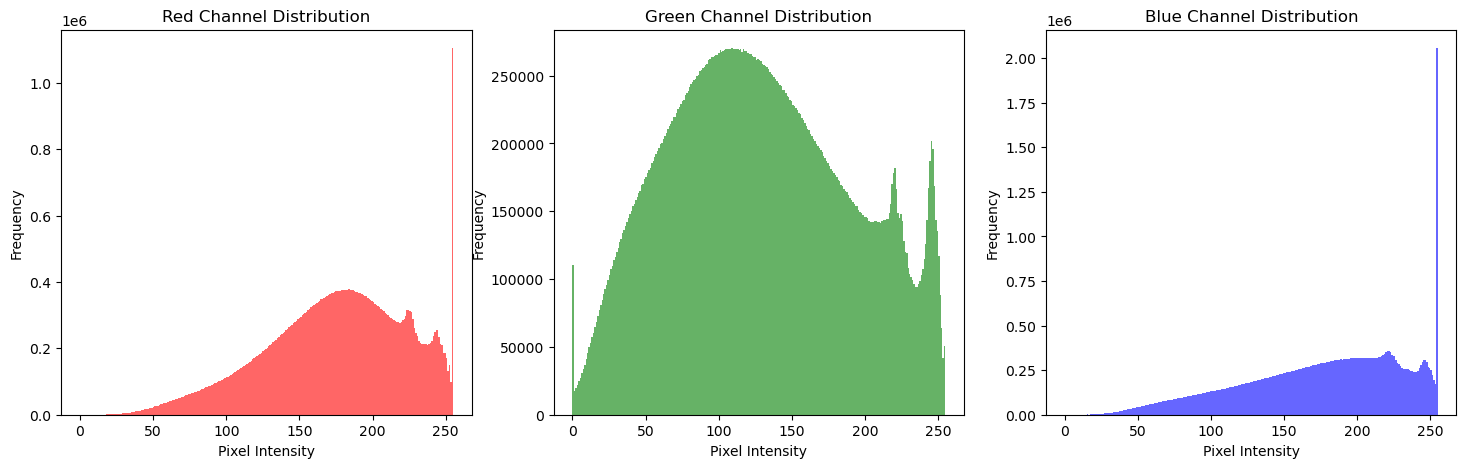

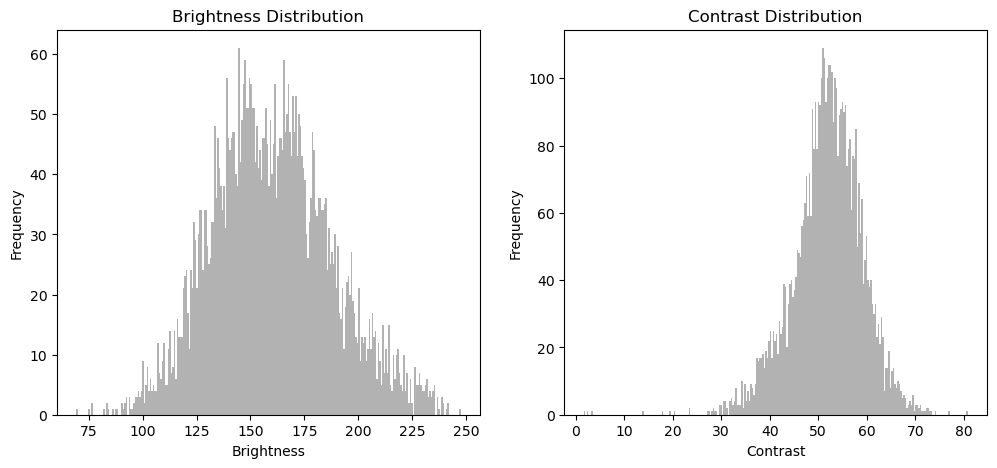

Label 1 - Mean: [175.13129136 128.5301788  176.3777247 ], Std: [47.74079896 61.94895323 54.05351133]
Label 1 - Average Brightness: 160.01306495225694, Average Contrast: 51.88039787156358


In [10]:
def compute_image_statistics(images):
    means = np.mean(images, axis=(0, 1, 2))
    stds = np.std(images, axis=(0, 1, 2))

    r_values = images[:, :, :, 0].flatten()
    g_values = images[:, :, :, 1].flatten()
    b_values = images[:, :, :, 2].flatten()

    plt.figure(figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.hist(r_values, bins=256, color='red', alpha=0.6)
    plt.title('Red Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(g_values, bins=256, color='green', alpha=0.6)
    plt.title('Green Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(b_values, bins=256, color='blue', alpha=0.6)
    plt.title('Blue Channel Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.show()

    brightness = np.mean(images, axis=(1, 2, 3))
    contrast = np.std(images, axis=(1, 2, 3))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(brightness, bins=256, color='gray', alpha=0.6)
    plt.title('Brightness Distribution')
    plt.xlabel('Brightness')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(contrast, bins=256, color='gray', alpha=0.6)
    plt.title('Contrast Distribution')
    plt.xlabel('Contrast')
    plt.ylabel('Frequency')

    plt.show()

    return means, stds, brightness.mean(), contrast.mean()

# Compute image statistics and plot distributions for label 0
mean_0, std_0, avg_brightness_0, avg_contrast_0 = compute_image_statistics(train_images_0)
print(f"Label 0 - Mean: {mean_0}, Std: {std_0}")
print(f"Label 0 - Average Brightness: {avg_brightness_0}, Average Contrast: {avg_contrast_0}")

# Compute image statistics and plot distributions for label 1
mean_1, std_1, avg_brightness_1, avg_contrast_1 = compute_image_statistics(train_images_1)
print(f"Label 1 - Mean: {mean_1}, Std: {std_1}")
print(f"Label 1 - Average Brightness: {avg_brightness_1}, Average Contrast: {avg_contrast_1}")


### Loading Augmented Images
Let's also quickly check the augmented images using ImageDataGenerator, to see if theres anything striking with the adjustments. The images do look quite different. ImageDataGenerator is typically useful for helping generalize a model. While I can't personally tell a major difference between these images, we will proceed with this none the less.

This code took inspiration from another Kaggle Project for the datagen.

Marazzi, F. (2018, November 26). Baseline Keras CNN - ROC - fast (10min) (0.925 lb). Kaggle. https://www.kaggle.com/code/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb?scriptVersionId=7784920 

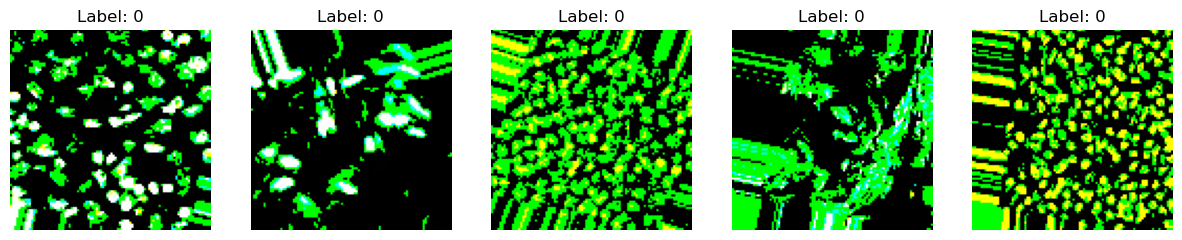

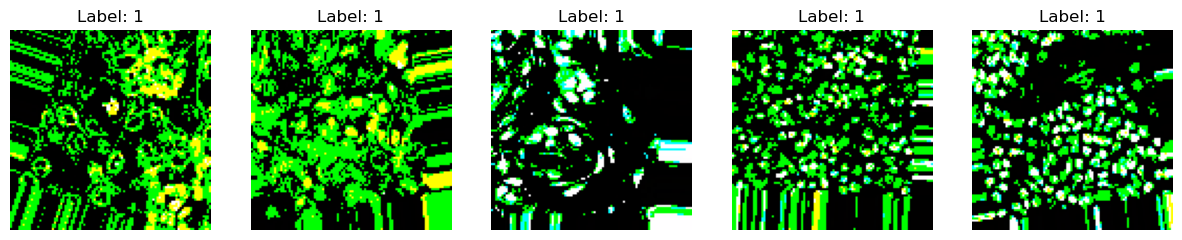

In [11]:
# Define data augmentation
datagen = ImageDataGenerator(preprocessing_function=lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             fill_mode='nearest')

# Display some augmented images
def plot_augmented_images(images, labels, datagen, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 15))
    for i, (img, label) in enumerate(zip(images, labels)):
        if i >= n:
            break
        augmented_image = next(datagen.flow(np.expand_dims(img, axis=0), np.expand_dims(label, axis=0)))[0].astype('uint8')[0]
        axes[i].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
        axes[i].set_title(f"Label: {int(label)}")
        axes[i].axis('off')
    plt.show()

# Plot augmented images
plot_augmented_images(train_images_0[:5], [0]*5, datagen, n=5)
plot_augmented_images(train_images_1[:5], [1]*5, datagen, n=5)

#### Memory Cleanup
Let's quickly cleanup the memory before starting the Modeling phase of this project. We will delete all the images we loaded and labels. We will also use gc library to clear some of the memory

In [12]:
del train_images_0
del train_images_1

gc.collect()

24433

## Model Building

First we will start by loading all the images for model training. We will then split the data into train and validation data sets using sklearn's train_test_split function. We will take a subset of the data of 80,000 Positive and Negative cancer presence. 

In [13]:
N = 80000
df_0 = train_labels[train_labels['label'] == 0].sample(N, random_state=101)
df_1 = train_labels[train_labels['label'] == 1].sample(N, random_state=101)
sampled_labels = pd.concat([df_0, df_1]).reset_index(drop=True)
sampled_image_paths = [os.path.join(train_path, f"{id}.tif") for id in sampled_labels['id']]

train_images = load_images(sampled_image_paths)
train_labels = sampled_labels['label'].values

Loading images:   0%|          | 0/160000 [00:00<?, ?it/s]

In [14]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=37)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")

Training set size: 128000
Validation set size: 32000


### Convolutional Model
We will start by initializing the model using relu as our primary activbation function. We will use an input size of 96,96 to correspond with the image size. This model consists of 3 layers and 1 output layer.

1st Layer
- 2 Convolutional layers with 32 filters using Relu as the activation function. Bias is off and we are using batch normalization to speed up the training. Finaling the model is pooled by taking the max of a 2x2 area. Dropout is set to 20% which increase with each layer.
- This results in 10,240 parameters for this layer.
  
2nd Layer
- 2 Convolutional layers with 64 filters using Relu as the activation function. Bias is off and we are using batch normalization to speed up the training. Finaling the model is pooled by taking the max of a 2x2 area. Dropout is set to 30% which increase with each layer.
- This results in 55,812 parameters for this layer.
  
3rd Layer
- 2 Convolutional layers with 128 filters using Relu as the activation function. Bias is off and we are using batch normalization to speed up the training. Finaling the model is pooled by taking the max of a 2x2 area. Dropout is set to 40% which increase with each layer.
- This results in 222,208 parameters for this layer.
  
Final Layer
- We utilize Flatten to convert the 2D map to a 1D feature vector.
- We use a fully connected dense layer with 256 units without bias. We perform 1 final round of batch normalization with a dropout of 50% now.
- This results in 2,097152 parameters for the dense layer with 257 parameters for the output.

The end result is a model with 2,386,689 total parameters of which 1,344 are not trainable.44
  

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    Activation("relu"),
    Conv2D(32, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 activation (Activation)     (None, 94, 94, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization (BatchN  (None, 92, 92, 32)       128       
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 32)       0         
 )                                                      

To start training the model, we need to compile it. We will start by initializing the Adam optimizer with a learning rate of 0.01 utilizing accuracy as our metric of choice and binary_crossentropy as our loss function due to the binary nature of this problem. 

We will utilize a batch of 32, e.g passing 32 images at a time to the model. Finally, we will initialize our model with 10 epochs or 10 rounds of running all the data through the model.

We will also use Earlystopper to end early if we reach a good state. ReduceLROnPlateau will also assist in updating the learning rate for the model to fine tune itself as it proceeds.

In [16]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

datagen = ImageDataGenerator(preprocessing_function=lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x,
                             horizontal_flip=True,
                             vertical_flip=True,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             fill_mode='nearest')

# Fit the generator to the training data
train_generator = datagen.flow(train_images, train_labels, batch_size=32)
val_generator = datagen.flow(val_images, val_labels, batch_size=32)

earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reducel, earlystopper])

Epoch 1/10
4000/4000 [==============================] - 259s 62ms/step - loss: 0.4461 - accuracy: 0.7995 - val_loss: 0.4006 - val_accuracy: 0.8272 - lr: 0.0100
Epoch 2/10
4000/4000 [==============================] - ETA: 0s - loss: 0.3922 - accuracy: 0.8309
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
4000/4000 [==============================] - 247s 62ms/step - loss: 0.3922 - accuracy: 0.8309 - val_loss: 0.4401 - val_accuracy: 0.8116 - lr: 0.0100
Epoch 3/10
4000/4000 [==============================] - 247s 62ms/step - loss: 0.3345 - accuracy: 0.8579 - val_loss: 0.2956 - val_accuracy: 0.8750 - lr: 1.0000e-03
Epoch 4/10
4000/4000 [==============================] - 249s 62ms/step - loss: 0.3200 - accuracy: 0.8674 - val_loss: 0.2929 - val_accuracy: 0.8771 - lr: 1.0000e-03
Epoch 5/10
4000/4000 [==============================] - 250s 62ms/step - loss: 0.3096 - accuracy: 0.8705 - val_loss: 0.2871 - val_accuracy: 0.8790 - lr: 1.0000e-03
Epoch 6/10
3999/4000 [===

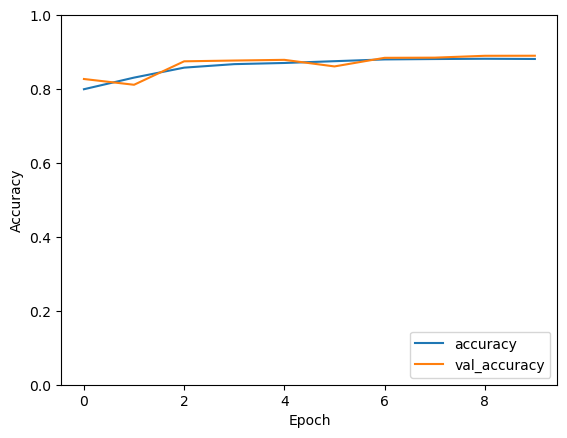

In [17]:
# Save the model
model.save('image_classifier_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

Overall, this performed well. The Learning rate reduction acts as a scheduler and allows the model to fine tune as it continues training. As the model did not reach a stopping point, i think we could benefit from training the model a little longer, so I will be adding 10 more epochs for further training. The model didnt gain to much performance but performed 3 more epochs. val accuracy seems to drop and loss increases so around 10 epochs seems correct. 

In [18]:
additional_epochs = 10
history_additional = model.fit(
    train_generator,
    epochs=additional_epochs,
    validation_data=val_generator,
    callbacks=[reducel, earlystopper])

# Combine the history objects if needed
history.history.update(history_additional.history)

Epoch 1/10
4000/4000 [==============================] - 247s 62ms/step - loss: 0.2872 - accuracy: 0.8821 - val_loss: 0.2704 - val_accuracy: 0.8863 - lr: 1.0000e-05
Epoch 2/10
3999/4000 [============================>.] - ETA: 0s - loss: 0.2851 - accuracy: 0.8836
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-07.
4000/4000 [==============================] - 248s 62ms/step - loss: 0.2851 - accuracy: 0.8835 - val_loss: 0.2706 - val_accuracy: 0.8870 - lr: 1.0000e-05
Epoch 3/10
4000/4000 [==============================] - 250s 62ms/step - loss: 0.2845 - accuracy: 0.8830 - val_loss: 0.2686 - val_accuracy: 0.8860 - lr: 1.0000e-06
Epoch 4/10
4000/4000 [==============================] - ETA: 0s - loss: 0.2851 - accuracy: 0.8829
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.99999883788405e-08.
4000/4000 [==============================] - 250s 63ms/step - loss: 0.2851 - accuracy: 0.8829 - val_loss: 0.2727 - val_accuracy: 0.8853 - lr: 1.0000e-06
Epoch 5/10
4000/4000

In [19]:
model = load_model('image_classifier_model.h5')
model.save_weights('Adam_model_weights_Flatten.h5')

### Model Update - Adding GlobalAveragePooling to the Final Layer
Here we will train the model additionally with GlobalAveragePooling before the Dense Layer. The Goal of this will be to see if Global Average Pooling performs better then flatten.


In [20]:
model2 = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    Activation("relu"),
    Conv2D(32, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(256, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 activation_7 (Activation)   (None, 94, 94, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_6 (Batc  (None, 92, 92, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                  

As we changed how our model works, we will need to partially retrain. That being said, we can still use the weights from some of the other layers, so we can manually load in weights from the original model and train from there to save some time. The Global Average 

In [21]:
model2.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Load weights from the original model
original_model = load_model('image_classifier_model.h5')

# Transfer weights from the original model to the new model
for layer in model2.layers:
    if layer.name in [layer.name for layer in original_model.layers]:
        original_layer = original_model.get_layer(name=layer.name)
        if layer.weights and original_layer.weights:
            layer.set_weights(original_layer.get_weights())

Epoch 1/10
4000/4000 [==============================] - 254s 63ms/step - loss: 0.4134 - accuracy: 0.8160 - val_loss: 0.4464 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 2/10
4000/4000 [==============================] - 250s 62ms/step - loss: 0.3463 - accuracy: 0.8522 - val_loss: 0.3377 - val_accuracy: 0.8575 - lr: 0.0010
Epoch 3/10
4000/4000 [==============================] - ETA: 0s - loss: 0.3188 - accuracy: 0.8660
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4000/4000 [==============================] - 249s 62ms/step - loss: 0.3188 - accuracy: 0.8660 - val_loss: 0.3497 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 4/10
4000/4000 [==============================] - 250s 62ms/step - loss: 0.2801 - accuracy: 0.8849 - val_loss: 0.2535 - val_accuracy: 0.8940 - lr: 1.0000e-04
Epoch 5/10
4000/4000 [==============================] - ETA: 0s - loss: 0.2700 - accuracy: 0.8897
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
4000/4000 [======

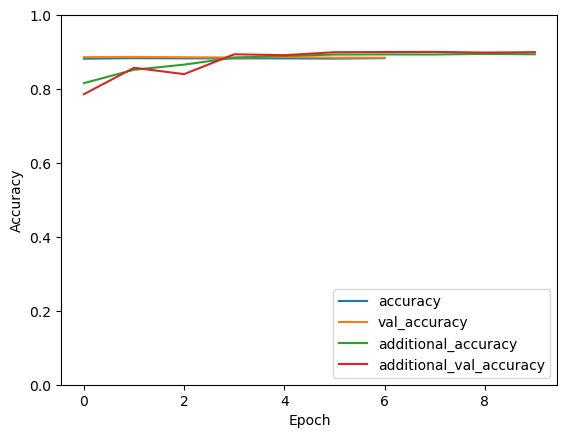

In [22]:
history_additional2 = model2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[reducel, earlystopper])

# Plot the combined training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history_additional2.history['accuracy'], label='additional_accuracy')
plt.plot(history_additional2.history['val_accuracy'], label='additional_val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, .75])
plt.legend(loc='lower right')
plt.show()

### RMSProp Model

Let's implement one last model using RMSProp as the optimizer instead of Adam. We will train this one from scratch due to the change in the optimizer. Since Flatten performed about equal or a little better to average global pooling, we will continue to use flatten for training this model. 

In [23]:
model_rmsprop = Sequential([
    Conv2D(32, (3, 3), input_shape=(96, 96, 3)),
    Activation("relu"),
    Conv2D(32, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Conv2D(128, (3, 3), use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, use_bias=False),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_rmsprop.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 94, 94, 32)        896       
                                                                 
 activation_14 (Activation)  (None, 94, 94, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 92, 92, 32)        9216      
                                                                 
 batch_normalization_12 (Bat  (None, 92, 92, 32)       128       
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 92, 92, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                  

Epoch 1/12
4000/4000 [==============================] - 271s 67ms/step - loss: 0.2788 - accuracy: 0.8876 - val_loss: 0.2341 - val_accuracy: 0.9101 - lr: 0.0010
Epoch 2/12
4000/4000 [==============================] - 265s 66ms/step - loss: 0.2727 - accuracy: 0.8912 - val_loss: 0.2303 - val_accuracy: 0.9072 - lr: 0.0010
Epoch 3/12
4000/4000 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8929
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4000/4000 [==============================] - 262s 65ms/step - loss: 0.2695 - accuracy: 0.8929 - val_loss: 0.2936 - val_accuracy: 0.8796 - lr: 0.0010
Epoch 4/12
4000/4000 [==============================] - 263s 66ms/step - loss: 0.2379 - accuracy: 0.9073 - val_loss: 0.2103 - val_accuracy: 0.9178 - lr: 1.0000e-04
Epoch 5/12
4000/4000 [==============================] - 263s 66ms/step - loss: 0.2368 - accuracy: 0.9082 - val_loss: 0.2053 - val_accuracy: 0.9183 - lr: 1.0000e-04
Epoch 6/12
4000/4000 [======

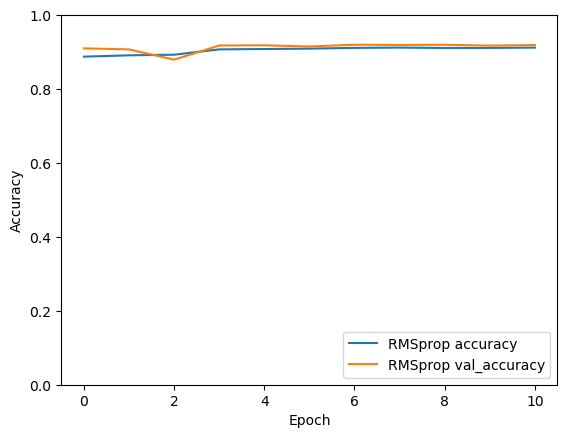

In [25]:
# Compile the model with RMSprop optimizer
model_rmsprop.compile(optimizer=RMSprop(learning_rate=0.001), 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])

# Fit the generator to the training data
train_generator = datagen.flow(train_images, train_labels, batch_size=32)
val_generator = datagen.flow(val_images, val_labels, batch_size=32)

earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

# Train the model
history_rmsprop = model_rmsprop.fit(
    train_generator,
    epochs=12,
    validation_data=val_generator,
    callbacks=[reducel, earlystopper])

# Plot the training history for the second model
plt.plot(history_rmsprop.history['accuracy'], label='RMSprop accuracy')
plt.plot(history_rmsprop.history['val_accuracy'], label='RMSprop val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([.8, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
model.save('RMSProp_classifier_model.h5')
model.save_weights('RMSProp_model_weights_Flatten.h5')

RMSProp appears to perform similarly to Adams reaching a 92% accuracy at 7 Epochs. It also appears to have trained faster due to needing less epochs to complete. The train and validation accuracy were both higher then Adams, so we will proceed with this model as our model of choice.

In [36]:
K.clear_session()
gc.collect()

final_model = load_model('RMSProp_classifier_model.h5')

## Testing the Model
Let's start by loading the test data and running it through the datagen so it's processed the same as the train data. We can pass shuffle = false since we don't need the data randomized. 

In [40]:
N = 80000

test_images = load_images(test_image_paths)
test_generator = datagen.flow(test_images, batch_size=32, shuffle=False)

Loading images:   0%|          | 0/57458 [00:00<?, ?it/s]

We can then run the test generator through the  prediction and output this as the final submission.csv file for submission to the Kaggle challenge. 

In [41]:
predictions = final_model.predict(test_generator, verbose = 1)

1796/1796 [==============================] - 224s 125ms/step


In [42]:
ids = [os.path.splitext(os.path.basename(path))[0] for path in test_image_paths]
predictions_df = pd.DataFrame({'id': ids, 'label': predictions.flatten()})

print(predictions_df.head())

                                         id     label
0  00006537328c33e284c973d7b39d340809f7271b  0.941402
1  0000ec92553fda4ce39889f9226ace43cae3364e  0.441012
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2  0.228615
3  000253dfaa0be9d0d100283b22284ab2f6b643f6  0.023475
4  000270442cc15af719583a8172c87cd2bd9c7746  0.021287


In [43]:
predictions_df.to_csv('submissions.csv', index=False)

## Conclusion
In conclusion, we have gone through multiple steps in our goal of categorizing images of cells to identify metastatic cancer. We started by loading the data utilizing libraries like glob, cv2, and tqdm. We then proceeded on to perform a simple EDA to get some general idea of the images. This EDA was focused mostly on the RGB values of the images. We found that the distribution of values varied greatly between cells that had metastatic cancer and cells that did not. 

We then proceeded into the Neural Network modeling phase where we utilized tensorflow to build a convolutional neural network. We tested 2 main optimizers of Adam and RMSProp and found that RMSProp performed slightly better. In these models we also implemented a ImageDataGenerator to help us generalize the images to prevent the model from overfitting. We also utilized Learning rate reduction on plateau to function as our Learning Rate scheduler to improve the speed of fitting it to our model. We also used Early stopping to find the optimal weights and prevent running to many Epochs.
